In [1]:
# The basics
import numpy as np
import pandas as pd

# Import Sklearn model libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score, precision_recall_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA


# Import Utility libraries
import shap
from collections import Counter
import pickle
from tqdm import tqdm_notebook
import warnings
import ipyparallel as ipp
import time
from termcolor import colored
import os
import csv
import matplotlib.pyplot as plt
import seaborn as sns
# Pre-run necessities
warnings.filterwarnings('ignore')
rnds = [60, 452, 774, 802, 961, 626, 726, 211, 375, 448, 883, 684, 724, 333, 64, 646, 116, 714, 483, 73, 562, 703, 276, 394, 190, 675, 314, 604, 297, 266, 456, 845, 822, 529, 420, 605, 935, 733, 167, 603, 401, 948, 241, 734, 550, 65, 429, 470, 633, 627, 223, 713, 958, 40, 200, 641, 357, 778, 781, 498, 202, 349, 983, 125, 548, 331, 206, 556, 356, 805, 246, 626, 358, 393, 307, 792, 777, 169, 595, 279, 719, 902, 124, 197, 983, 499, 368, 864, 896, 887, 879, 224, 220, 926, 565, 173, 919, 3, 908, 941]

In [2]:
# '''
# Code for getting plots on attack metrics, target performance for number of estimator analysis
# Plots show mean values.
# '''
# def read_file(run,dataset_name,influence_type):

#     parent_dir = '/home/amanmoha/influence_attack/results/actual/estimator_analysis'
    
#     directory = dataset_name+'/'+influence_type+'/'+'run'+run
#     path = os.path.join(parent_dir,directory)
    
#     with open(path+'/metrics.txt','r') as f:
#         lines = f.readlines()
#     f.close()
    
#     data = []
#     for line in lines:
#         d_ = line.split('\t')
#         if d_[-1] != '\n':
#             if d_[-1][1] == 'n' or d_[-1][1] == 'm':
#                 data.append(int(d_[-1][d_[-1].index('=')+1:-1]))
#             else:
#                 data.append(np.round(float(d_[-1].strip(' \n')),3))
#     return data

# run = '3'
# dataset_name = 'pima_diabetes'
# influence_type = 'SHAP'

# data = read_file(run,dataset_name,influence_type)
# n_est,max_d,tar_tr,tar_te,att_ac,att_pr,att_re,att_f1 = [],[],[],[],[],[],[],[]
# i = 0
# data = data[360:]
# while i < len(data):
#     n_est.append(data[i])
#     max_d.append(data[i+1])
#     tar_tr.append(data[i+2])
#     tar_te.append(data[i+3])
#     att_ac.append(data[i+4])
#     att_pr.append(data[i+5])
#     att_re.append(data[i+6])
#     att_f1.append(data[i+7])
    
#     i+=12

# plt.figure(1,figsize=(10,6))
# plt.plot(n_est,tar_tr,'-o',label='Train accuracy')
# plt.plot(n_est,tar_te,'-o',label='Test accuracy')
# plt.xlabel('Number of estimators')
# plt.ylabel('Accuracy')
# plt.legend()

# plt.figure(2,figsize=(10,6))
# plt.plot(n_est,att_ac,label='Attack accuracy')
# plt.plot(n_est,att_pr,label='Attack precision')
# plt.plot(n_est,att_re,label='Attack recall')
# plt.plot(n_est,att_f1,label='Attack f1')
# plt.xlabel('Number of estimators')
# plt.ylabel('Metric')
# plt.legend()
# plt.show()

########## hepatitis-SHAP ##########


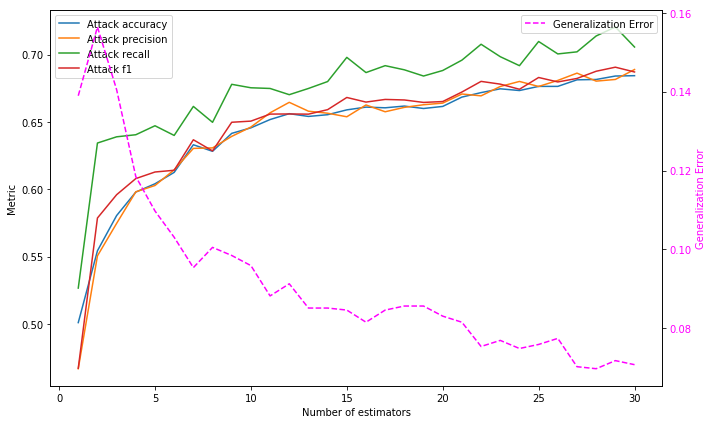

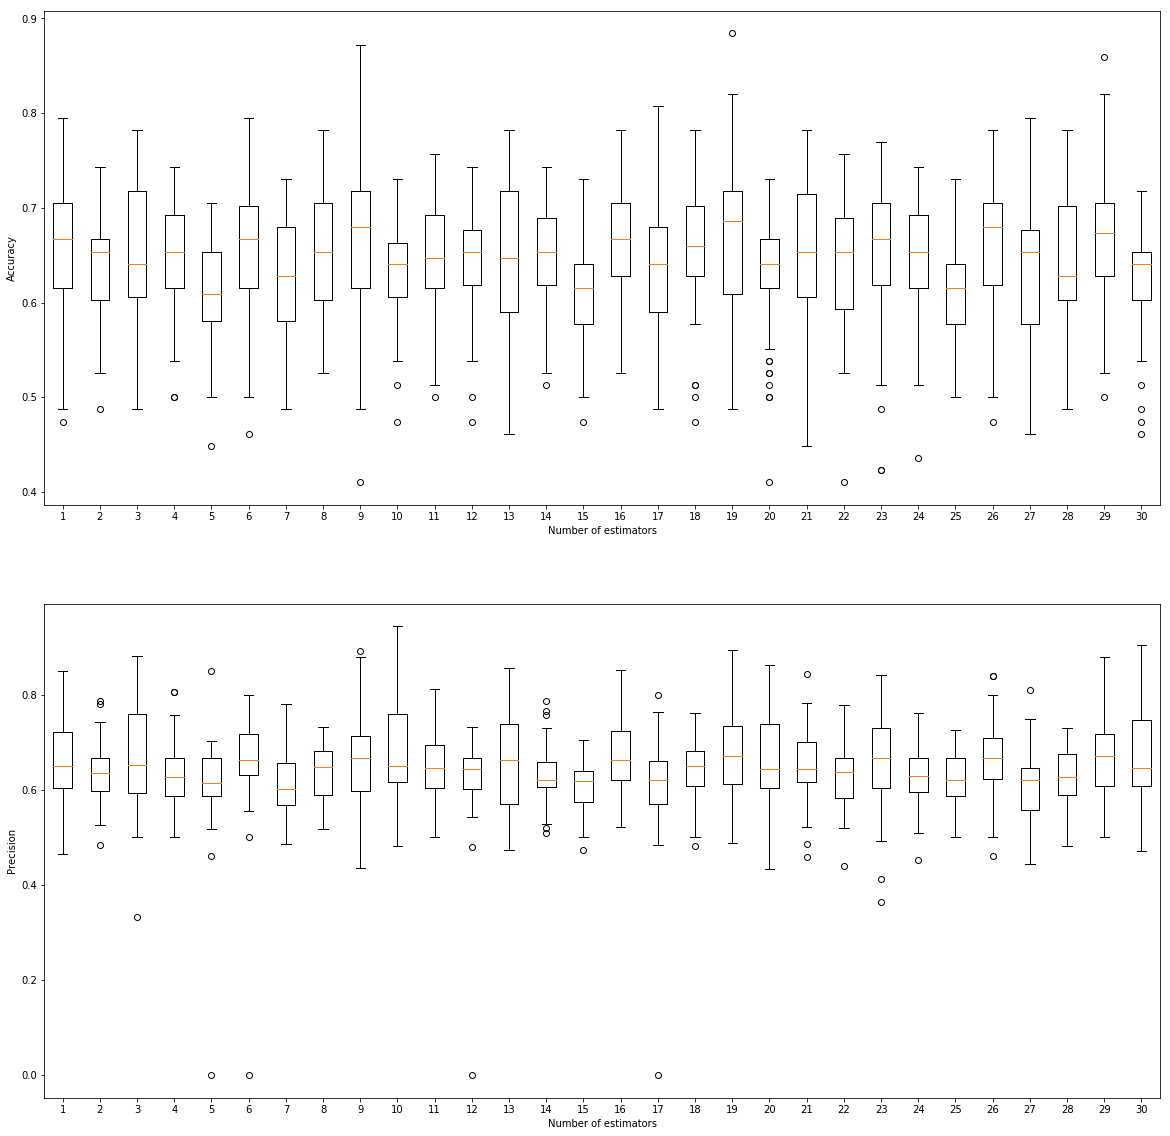

In [13]:
def read_file(run,dataset_name,influence_type,n_ests):

#     parent_dir = '/home/amanmoha/influence_attack/results/actual/estimator_analysis'
    parent_dir = '/home/amanmoha/influence_attack/results/actual/estimator_analysis'
    tr_ac_est,te_ac_est,ac_est,ps_est,rs_est,fs_est = [],[],[],[],[],[]
    for n_est in range(1,n_ests+1):
        directory = dataset_name+'/'+influence_type+'/'+'run'+run+'/'+'n_est-'+str(n_est)
        path = os.path.join(parent_dir,directory)
    
        with open(path+'/metrics.txt','rb') as f:
            metrics = pickle.load(f)
        f.close()
    
        tr_ac,te_ac,ac,ps,rs,fs,ac_b,ps_b,rs_b,fs_b = metrics[0],metrics[1],metrics[2],metrics[3],metrics[4],metrics[5],metrics[6],metrics[7],metrics[8],metrics[9]
        tr_ac_est.append(tr_ac)
        te_ac_est.append(te_ac)
        ac_est.append(ac)
        ps_est.append(ps)
        rs_est.append(rs)
        fs_est.append(fs)
    return np.array(tr_ac_est),np.array(te_ac_est),np.array(ac_est),np.array(ps_est),np.array(rs_est),np.array(fs_est)

run = '5'
dataset_name = 'hepatitis'
influence_type = 'SHAP'
n_ests = 30

tr_ac_est,te_ac_est,ac_est,ps_est,rs_est,fs_est = read_file(run,dataset_name,influence_type,n_ests)
n_est=np.arange(1,n_ests+1,1)


# plt.figure(1,figsize=(15,8))
# plt.plot(n_est,np.mean(tr_ac_est,axis=1),'-o',label='Train accuracy')
# plt.plot(n_est,np.mean(te_ac_est,axis=1),'-o',label='Test accuracy')
# plt.xlabel('Number of estimators')
# plt.ylabel('Accuracy')
# plt.legend()
print("########## {c}-{d} ##########".format(c=dataset_name,d=influence_type))


# MEAN PLOTS

gen_err = np.subtract(np.mean(tr_ac_est,axis=1),np.mean(te_ac_est,axis=1))
fig, ax = plt.subplots(figsize=(10,6))
ax.set_xlabel('Number of estimators')
ax.set_ylabel('Metric')
ax.plot(n_est,np.mean(ac_est,axis=1),label='Attack accuracy')
ax.plot(n_est,np.mean(ps_est,axis=1),label='Attack precision')
ax.plot(n_est,np.mean(rs_est,axis=1),label='Attack recall')
ax.plot(n_est,np.mean(fs_est,axis=1),label='Attack f1')
ax.tick_params(axis='y')

axtwin = ax.twinx()  # instantiate a second axes that shares the same x-axis
axtwin.set_ylabel('Generalization Error',color='magenta')  # we already handled the x-label with ax1
axtwin.plot(n_est,gen_err,'--',label='Generalization Error',color='magenta')
axtwin.tick_params(axis='y',labelcolor='magenta')
# ax.set_ylim(0.4,0.7)

if dataset_name == 'german_credit':
    axtwin.set_ylim(0.07,0.14)
elif dataset_name == 'bcw':
    axtwin.set_ylim(0.03,0.07)
elif dataset_name == 'pima_diabetes':
    axtwin.set_ylim(0.06,0.11)


ax.legend(loc='upper left')
axtwin.legend(loc='upper right')
fig.tight_layout()  # otherwise the right y-label is slightly clipped

# BOX PLOTS

f,ax=plt.subplots(2,1,figsize=(20,20))
f1=ax[0].boxplot(ac_est.reshape(50,n_ests))
f2=ax[1].boxplot(ps_est.reshape(50,n_ests))
ax[0].set_xlabel('Number of estimators')
ax[0].set_ylabel('Accuracy')
ax[1].set_xlabel('Number of estimators')
ax[1].set_ylabel('Precision')

plt.show()

########## hepatitis-SHAP ##########


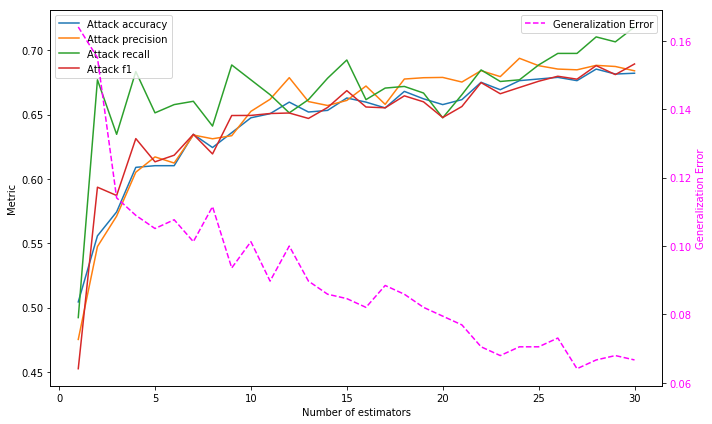

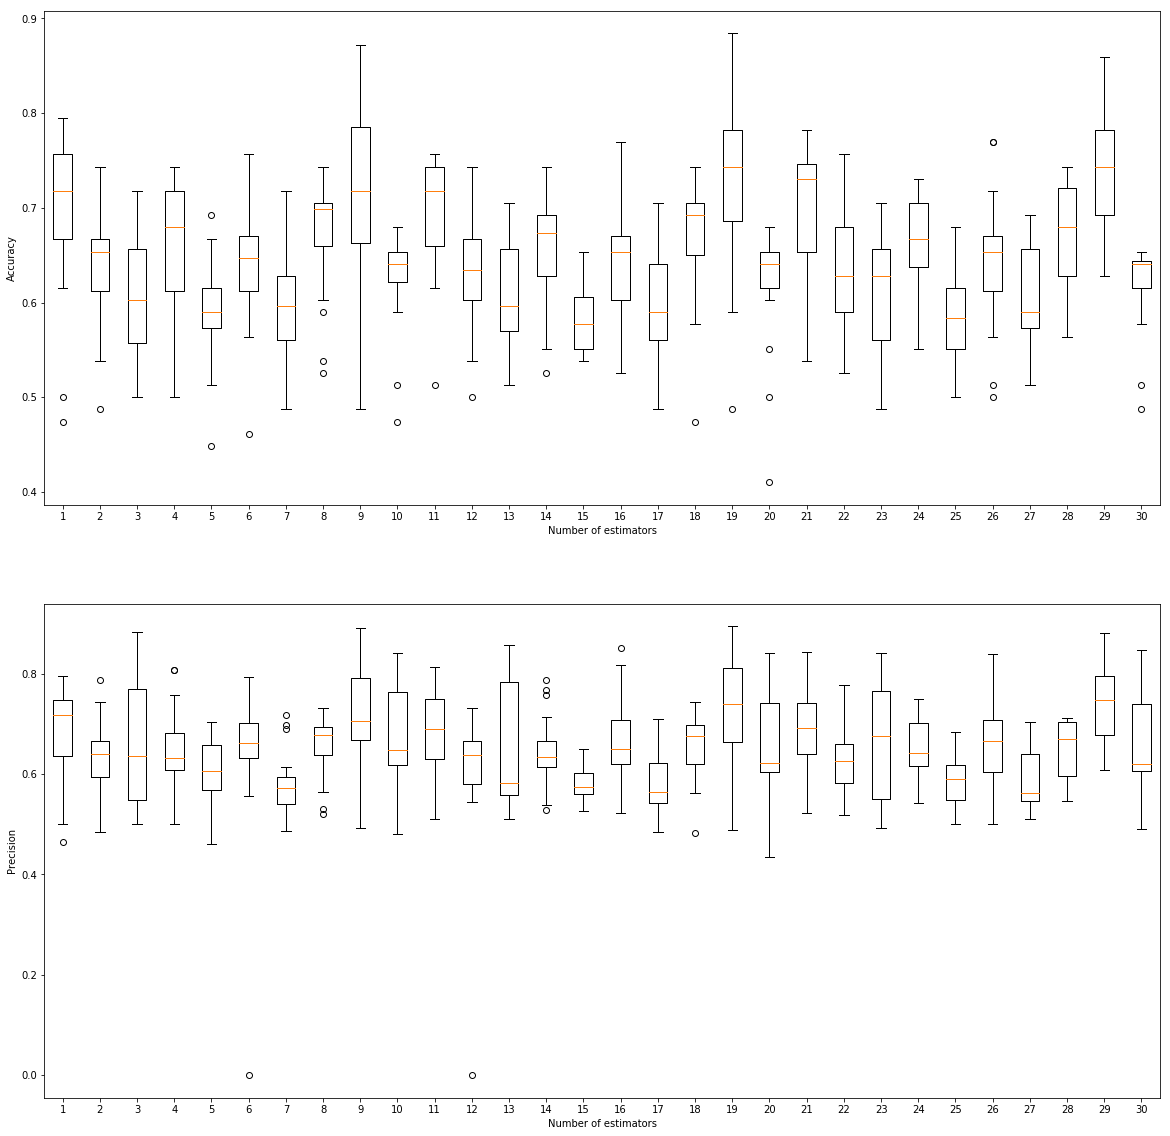

In [14]:
def read_file(run,dataset_name,influence_type,n_ests):

    parent_dir = '/home/amanmoha/influence_attack/results/actual/estimator_analysis'
    tr_ac_est,te_ac_est,ac_est,ps_est,rs_est,fs_est = [],[],[],[],[],[]
    for n_est in range(1,n_ests+1):
        directory = dataset_name+'/'+influence_type+'/'+'run'+run+'/'+'n_est-'+str(n_est)
        path = os.path.join(parent_dir,directory)
    
        with open(path+'/metrics.txt','rb') as f:
            metrics = pickle.load(f)
        f.close()
    
        tr_ac,te_ac,ac,ps,rs,fs,ac_b,ps_b,rs_b,fs_b = metrics[0],metrics[1],metrics[2],metrics[3],metrics[4],metrics[5],metrics[6],metrics[7],metrics[8],metrics[9]
        tr_ac_est.append(tr_ac)
        te_ac_est.append(te_ac)
        ac_est.append(ac)
        ps_est.append(ps)
        rs_est.append(rs)
        fs_est.append(fs)
    return np.array(tr_ac_est),np.array(te_ac_est),np.array(ac_est),np.array(ps_est),np.array(rs_est),np.array(fs_est)

run = '4'
dataset_name = 'hepatitis'
influence_type = 'SHAP'
n_ests = 30

tr_ac_est,te_ac_est,ac_est,ps_est,rs_est,fs_est = read_file(run,dataset_name,influence_type,n_ests)
n_est=np.arange(1,n_ests+1,1)


# plt.figure(1,figsize=(15,8))
# plt.plot(n_est,np.mean(tr_ac_est,axis=1),'-o',label='Train accuracy')
# plt.plot(n_est,np.mean(te_ac_est,axis=1),'-o',label='Test accuracy')
# plt.xlabel('Number of estimators')
# plt.ylabel('Accuracy')
# plt.legend()
print("########## {c}-{d} ##########".format(c=dataset_name,d=influence_type))


# MEAN PLOTS

gen_err = np.subtract(np.mean(tr_ac_est,axis=1),np.mean(te_ac_est,axis=1))
fig, ax = plt.subplots(figsize=(10,6))
ax.set_xlabel('Number of estimators')
ax.set_ylabel('Metric')
ax.plot(n_est,np.mean(ac_est,axis=1),label='Attack accuracy')
ax.plot(n_est,np.mean(ps_est,axis=1),label='Attack precision')
ax.plot(n_est,np.mean(rs_est,axis=1),label='Attack recall')
ax.plot(n_est,np.mean(fs_est,axis=1),label='Attack f1')
ax.tick_params(axis='y')

axtwin = ax.twinx()  # instantiate a second axes that shares the same x-axis
axtwin.set_ylabel('Generalization Error',color='magenta')  # we already handled the x-label with ax1
axtwin.plot(n_est,gen_err,'--',label='Generalization Error',color='magenta')
axtwin.tick_params(axis='y',labelcolor='magenta')
# ax.set_ylim(0.4,0.7)

if dataset_name == 'german_credit':
    axtwin.set_ylim(0.07,0.14)
elif dataset_name == 'bcw':
    axtwin.set_ylim(0.03,0.07)
elif dataset_name == 'pima_diabetes':
    axtwin.set_ylim(0.06,0.11)


ax.legend(loc='upper left')
axtwin.legend(loc='upper right')
fig.tight_layout()  # otherwise the right y-label is slightly clipped

# BOX PLOTS

f,ax=plt.subplots(2,1,figsize=(20,20))
f1=ax[0].boxplot(ac_est.reshape(20,n_ests))
f2=ax[1].boxplot(ps_est.reshape(20,n_ests))
ax[0].set_xlabel('Number of estimators')
ax[0].set_ylabel('Accuracy')
ax[1].set_xlabel('Number of estimators')
ax[1].set_ylabel('Precision')

plt.show()

########## bcw-SHAP ##########


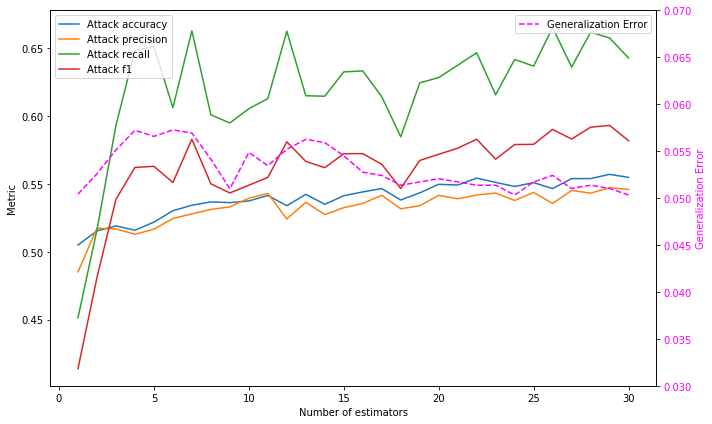

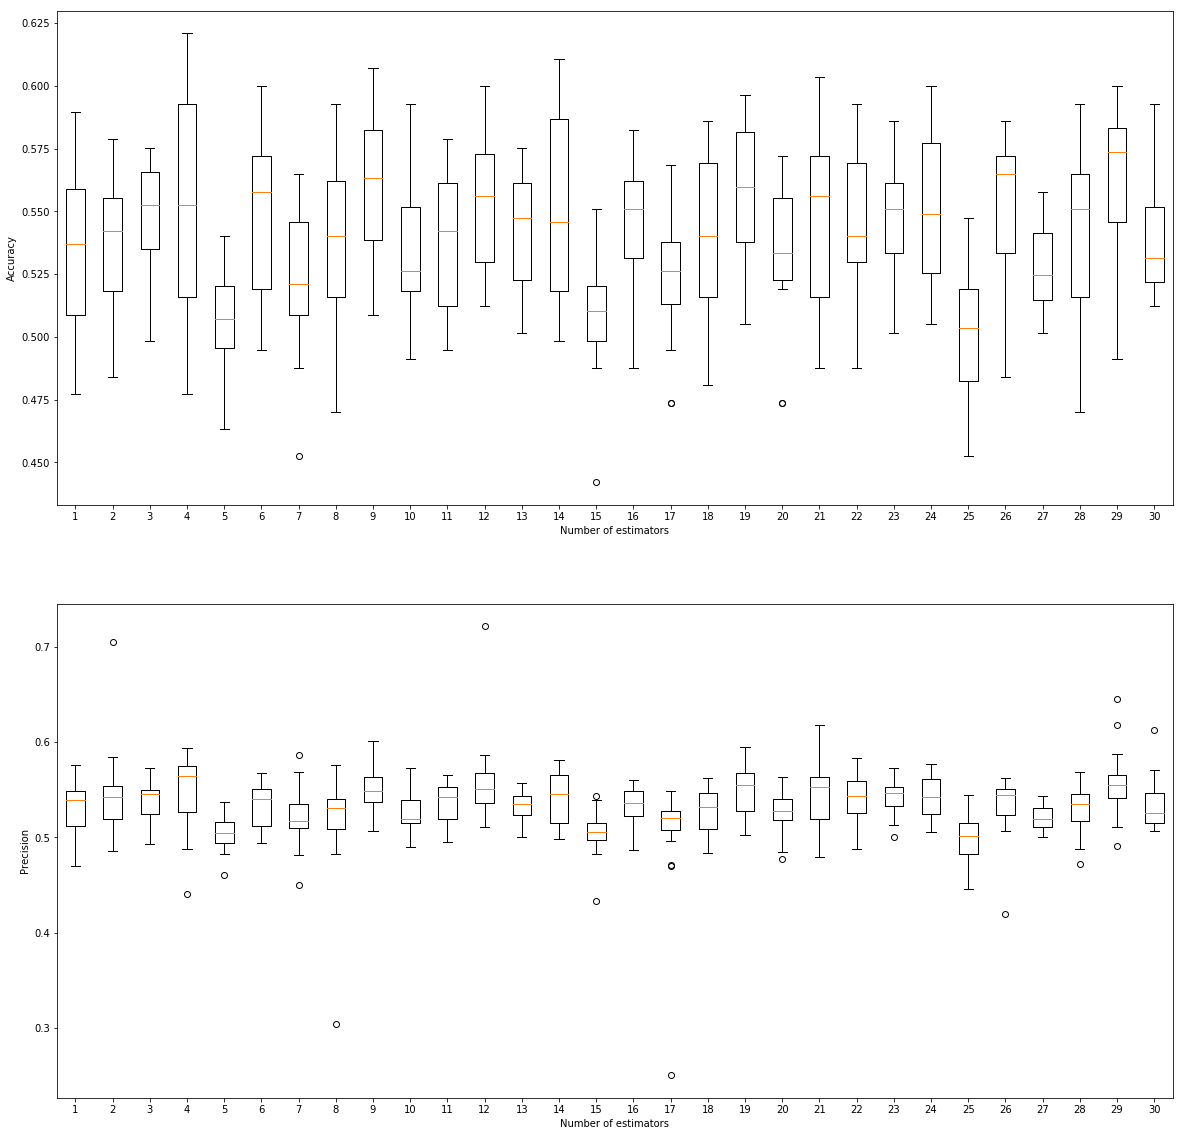

In [11]:
def read_file(run,dataset_name,influence_type,n_ests):

    parent_dir = '/home/amanmoha/influence_attack/results/actual/estimator_analysis'
    tr_ac_est,te_ac_est,ac_est,ps_est,rs_est,fs_est = [],[],[],[],[],[]
    for n_est in range(1,n_ests+1):
        directory = dataset_name+'/'+influence_type+'/'+'run'+run+'/'+'n_est-'+str(n_est)
        path = os.path.join(parent_dir,directory)
    
        with open(path+'/metrics.txt','rb') as f:
            metrics = pickle.load(f)
        f.close()
    
        tr_ac,te_ac,ac,ps,rs,fs,ac_b,ps_b,rs_b,fs_b = metrics[0],metrics[1],metrics[2],metrics[3],metrics[4],metrics[5],metrics[6],metrics[7],metrics[8],metrics[9]
        tr_ac_est.append(tr_ac)
        te_ac_est.append(te_ac)
        ac_est.append(ac)
        ps_est.append(ps)
        rs_est.append(rs)
        fs_est.append(fs)
    return np.array(tr_ac_est),np.array(te_ac_est),np.array(ac_est),np.array(ps_est),np.array(rs_est),np.array(fs_est)

run = '4'
dataset_name = 'bcw'
influence_type = 'SHAP'
n_ests = 30

tr_ac_est,te_ac_est,ac_est,ps_est,rs_est,fs_est = read_file(run,dataset_name,influence_type,n_ests)
n_est=np.arange(1,n_ests+1,1)


# plt.figure(1,figsize=(15,8))
# plt.plot(n_est,np.mean(tr_ac_est,axis=1),'-o',label='Train accuracy')
# plt.plot(n_est,np.mean(te_ac_est,axis=1),'-o',label='Test accuracy')
# plt.xlabel('Number of estimators')
# plt.ylabel('Accuracy')
# plt.legend()
print("########## {c}-{d} ##########".format(c=dataset_name,d=influence_type))


# MEAN PLOTS

gen_err = np.subtract(np.mean(tr_ac_est,axis=1),np.mean(te_ac_est,axis=1))
fig, ax = plt.subplots(figsize=(10,6))
ax.set_xlabel('Number of estimators')
ax.set_ylabel('Metric')
ax.plot(n_est,np.mean(ac_est,axis=1),label='Attack accuracy')
ax.plot(n_est,np.mean(ps_est,axis=1),label='Attack precision')
ax.plot(n_est,np.mean(rs_est,axis=1),label='Attack recall')
ax.plot(n_est,np.mean(fs_est,axis=1),label='Attack f1')
ax.tick_params(axis='y')

axtwin = ax.twinx()  # instantiate a second axes that shares the same x-axis
axtwin.set_ylabel('Generalization Error',color='magenta')  # we already handled the x-label with ax1
axtwin.plot(n_est,gen_err,'--',label='Generalization Error',color='magenta')
axtwin.tick_params(axis='y',labelcolor='magenta')
# ax.set_ylim(0.4,0.7)

if dataset_name == 'german_credit':
    axtwin.set_ylim(0.07,0.14)
elif dataset_name == 'bcw':
    axtwin.set_ylim(0.03,0.07)
elif dataset_name == 'pima_diabetes':
    axtwin.set_ylim(0.06,0.11)


ax.legend(loc='upper left')
axtwin.legend(loc='upper right')
fig.tight_layout()  # otherwise the right y-label is slightly clipped

# BOX PLOTS

f,ax=plt.subplots(2,1,figsize=(20,20))
f1=ax[0].boxplot(ac_est.reshape(20,n_ests))
f2=ax[1].boxplot(ps_est.reshape(20,n_ests))
ax[0].set_xlabel('Number of estimators')
ax[0].set_ylabel('Accuracy')
ax[1].set_xlabel('Number of estimators')
ax[1].set_ylabel('Precision')

plt.show()

########## german_credit-SHAP ##########


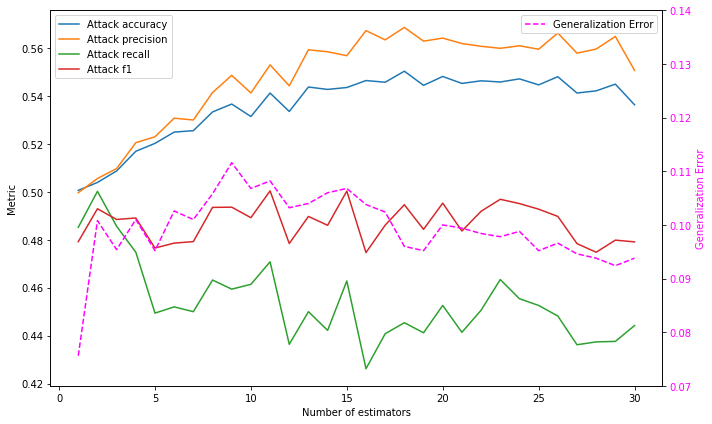

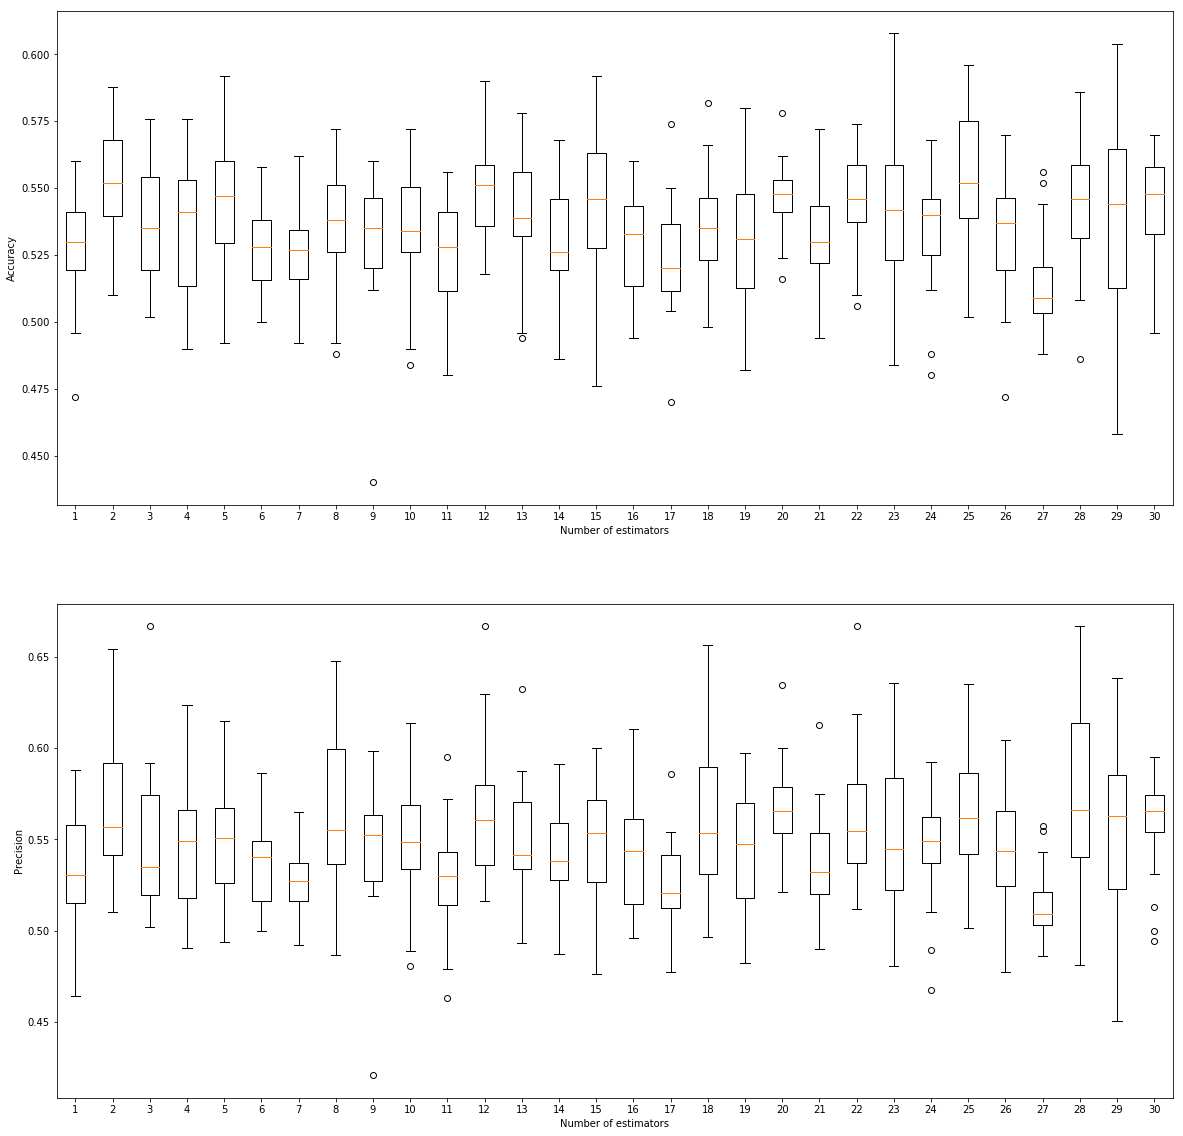

In [12]:
def read_file(run,dataset_name,influence_type,n_ests):

    parent_dir = '/home/amanmoha/influence_attack/results/actual/estimator_analysis'
    tr_ac_est,te_ac_est,ac_est,ps_est,rs_est,fs_est = [],[],[],[],[],[]
    for n_est in range(1,n_ests+1):
        directory = dataset_name+'/'+influence_type+'/'+'run'+run+'/'+'n_est-'+str(n_est)
        path = os.path.join(parent_dir,directory)
    
        with open(path+'/metrics.txt','rb') as f:
            metrics = pickle.load(f)
        f.close()
    
        tr_ac,te_ac,ac,ps,rs,fs,ac_b,ps_b,rs_b,fs_b = metrics[0],metrics[1],metrics[2],metrics[3],metrics[4],metrics[5],metrics[6],metrics[7],metrics[8],metrics[9]
        tr_ac_est.append(tr_ac)
        te_ac_est.append(te_ac)
        ac_est.append(ac)
        ps_est.append(ps)
        rs_est.append(rs)
        fs_est.append(fs)
    return np.array(tr_ac_est),np.array(te_ac_est),np.array(ac_est),np.array(ps_est),np.array(rs_est),np.array(fs_est)

run = '4'
dataset_name = 'german_credit'
influence_type = 'SHAP'
n_ests = 30

tr_ac_est,te_ac_est,ac_est,ps_est,rs_est,fs_est = read_file(run,dataset_name,influence_type,n_ests)
n_est=np.arange(1,n_ests+1,1)


# plt.figure(1,figsize=(15,8))
# plt.plot(n_est,np.mean(tr_ac_est,axis=1),'-o',label='Train accuracy')
# plt.plot(n_est,np.mean(te_ac_est,axis=1),'-o',label='Test accuracy')
# plt.xlabel('Number of estimators')
# plt.ylabel('Accuracy')
# plt.legend()
print("########## {c}-{d} ##########".format(c=dataset_name,d=influence_type))


# MEAN PLOTS

gen_err = np.subtract(np.mean(tr_ac_est,axis=1),np.mean(te_ac_est,axis=1))
fig, ax = plt.subplots(figsize=(10,6))
ax.set_xlabel('Number of estimators')
ax.set_ylabel('Metric')
ax.plot(n_est,np.mean(ac_est,axis=1),label='Attack accuracy')
ax.plot(n_est,np.mean(ps_est,axis=1),label='Attack precision')
ax.plot(n_est,np.mean(rs_est,axis=1),label='Attack recall')
ax.plot(n_est,np.mean(fs_est,axis=1),label='Attack f1')
ax.tick_params(axis='y')

axtwin = ax.twinx()  # instantiate a second axes that shares the same x-axis
axtwin.set_ylabel('Generalization Error',color='magenta')  # we already handled the x-label with ax1
axtwin.plot(n_est,gen_err,'--',label='Generalization Error',color='magenta')
axtwin.tick_params(axis='y',labelcolor='magenta')
# ax.set_ylim(0.4,0.7)

if dataset_name == 'german_credit':
    axtwin.set_ylim(0.07,0.14)
elif dataset_name == 'bcw':
    axtwin.set_ylim(0.03,0.07)
elif dataset_name == 'pima_diabetes':
    axtwin.set_ylim(0.06,0.11)


ax.legend(loc='upper left')
axtwin.legend(loc='upper right')
fig.tight_layout()  # otherwise the right y-label is slightly clipped

# BOX PLOTS

f,ax=plt.subplots(2,1,figsize=(20,20))
f1=ax[0].boxplot(ac_est.reshape(20,n_ests))
f2=ax[1].boxplot(ps_est.reshape(20,n_ests))
ax[0].set_xlabel('Number of estimators')
ax[0].set_ylabel('Accuracy')
ax[1].set_xlabel('Number of estimators')
ax[1].set_ylabel('Precision')

plt.show()